In [3]:
import pandas as pd
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
sns.set()
!pip install transformers
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report

import torch, transformers
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.11.0+cu113 Device: cuda [Tesla T4]


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('books_def.csv')
df = df[df.genres.isin(['Fiction', 'Nonfiction'])]
df['genres'] = df.genres.replace('Fiction', 1).replace('Nonfiction', 0)

In [6]:
label_map = {'Fiction': 1, 'Nonfiction': 0}
n_categories = df.genres.nunique()
label = np.asarray(df.pop('genres'))
text = np.asarray(df['book_desc'])

In [7]:
train_set, test_set, train_label, test_label = train_test_split(text, 
                                           label, stratify=label, test_size=0.30, random_state=42)

In [8]:
sentences_train = ["<s> " + s for s in train_set]
sentences_test = ["<s> " + s for s in test_set]
labels_train = train_label
labels_test  = test_label

In [9]:
ROBERTAMODEL = "roberta-base"
tokenizer = transformers.RobertaTokenizer.from_pretrained(ROBERTAMODEL, do_lower_case=True)

In [11]:
from tqdm import tqdm
tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]


100%|██████████| 9532/9532 [00:24<00:00, 381.59it/s]

100%|██████████| 4086/4086 [00:05<00:00, 747.10it/s]


In [12]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 256

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['</s>'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['</s>'] for t in tokenized_test]

In [13]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

In [14]:
amasks_train, amasks_test = [], []

for seq in ids_train:
    seq_mask = [float(i>0) for i in seq]
    amasks_train.append(seq_mask)

for seq in ids_test:
    seq_mask = [float(i>0) for i in seq]
    amasks_test.append(seq_mask)

In [15]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

In [16]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [17]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 8578 documents
Validation: 954 documents
Test: 4086 documents


In [18]:
model = transformers.RobertaForSequenceClassification.from_pretrained(ROBERTAMODEL,
                                                      num_labels=n_categories)
model.cuda()
print('Pretrained ROBERTA model "{}" loaded'.format(ROBERTAMODEL))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Pretrained ROBERTA model "roberta-base" loaded


In [19]:
EPOCHS = 3
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader):
    model.eval()
    n_correct, n_all = 0, 0
    predicted_labels = list()
    true_labels = list()
    
    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)
            logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)

        labels = b_labels.to('cpu').numpy()
        n_correct += np.sum(predictions == labels)

        true_labels.extend(labels)
        predicted_labels.extend(predictions)
        n_all += len(labels)

    print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
    print('Classification report:')
    print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
    print('Confusion matrix:')
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

In [21]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/8578 (0%)]	Loss: 0.678186
Train Epoch: 1 [6400/8578 (74%)]	Loss: 0.196013

Validation set:
Accuracy: [881/954] 0.9235
Classification report:
              precision    recall  f1-score   support

  Nonfiction       0.90      0.94      0.92       446
     Fiction       0.95      0.91      0.93       508

    accuracy                           0.92       954
   macro avg       0.92      0.92      0.92       954
weighted avg       0.92      0.92      0.92       954

Confusion matrix:
[[420  26]
 [ 47 461]]

Train Epoch: 2 [0/8578 (0%)]	Loss: 0.081714
Train Epoch: 2 [6400/8578 (74%)]	Loss: 0.440118

Validation set:
Accuracy: [875/954] 0.9172
Classification report:
              precision    recall  f1-score   support

  Nonfiction       0.88      0.95      0.91       446
     Fiction       0.95      0.89      0.92       508

    accuracy                           0.92       954
   macro avg       0.92      0.92      0.92       954
weighted avg       0.92      0.92      0

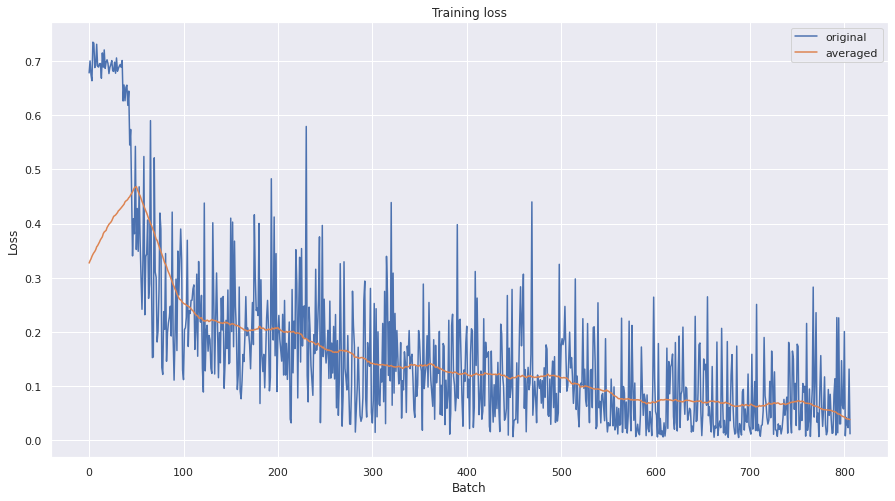

In [22]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

In [23]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [3902/4086] 0.9550
Classification report:
              precision    recall  f1-score   support

  Nonfiction       0.95      0.96      0.95      1951
     Fiction       0.96      0.95      0.96      2135

    accuracy                           0.95      4086
   macro avg       0.95      0.96      0.95      4086
weighted avg       0.96      0.95      0.95      4086

Confusion matrix:
[[1868   83]
 [ 101 2034]]
